In [1]:
#load dependancies
import json,os
import matplotlib.pyplot as plt
import numpy as np
from plotting_utils import plotXYZcross,PlotMouseSkel3D

In [2]:
%matplotlib notebook

In [3]:
#Change this path to the downloaded data 
path2base=''

In [8]:
# load example predictions aswell as annotations
files_annos='FreiPose_mouse/eval_set/anno.json'
files_preds='FreiPose_mouse/eval_pred.json'

#load the annotaions and predictions 
with open(path2base+files_annos,'rt') as fi:
    anno=json.load(fi)
with open(path2base+files_preds,'rt') as fi:
    preds=json.load(fi) 

# calculate the prediction error
gt=list()
p=list()
for frame in preds.keys():   
    gt.append(np.array(anno[frame]["xyz"]))
    p.append(np.squeeze(np.array(preds[frame]["kp_xyz"])))
gt=np.concatenate(gt) #ground truth
p=np.concatenate(p) # predictions

t = np.linalg.norm(gt - p, 2, -1) # JPE error in meters
median_error=np.median(t)
print("The median error %0.2f cm"%(median_error*100))

The median error 0.23 cm


In [5]:
# Now plotting the 3D predictions in individual views
# using the camera calibrations to project the 3d points into individual views
def PlotMouseImages(path2base,image2plot,draw_skel=False,undistort=True):  
    from imageio import imread
    import wrapped_sfmtools.CamLib as cl
    import cv2
    
    # load the calibration data
    calib_path = os.path.join(path2base,'FreiPose_mouse', 'M.json')
    with open(calib_path, 'r') as fi:
        calib = json.load(fi)
    cam_range=[1,2,3,4]
    K_list = [np.array(calib['K']['cam%d' % cid]) for cid in cam_range]
    M_list = [np.linalg.inv(np.array(calib['M']['cam%d' % cid])) for cid in cam_range]
    dist_list = [np.array(calib['dist']['cam%d' % cid]) for cid in cam_range]
    
    #get prediction for image
    xyz = np.squeeze(np.array(preds[image2plot]["kp_xyz"]))
    fig,ax=plt.subplots(2,2) 

    for ii,cam_id in enumerate([1,2,3,4]):
        img = imread(os.path.join(path2base,'FreiPose_mouse','eval_set','cam%d'%cam_id,image2plot))
        if undistort:
            img = cv2.undistort(img, K_list[cam_id-1], dist_list[cam_id-1]) # undistort image
        index_2use=np.unravel_index(ii,(2,2))
        ax[index_2use].imshow(img[:, :, ::-1]) #from bgr to rgb
        uv = cl.project(cl.trafo_coords(xyz, M_list[cam_id-1]), K_list[cam_id-1]) # project 3D keypoints into the corresponding camera view
        
        for p in uv:
            ax[index_2use].plot(p[0],p[1],'.',markersize=10)
        if draw_skel:
            neck=np.mean([uv[0,:],uv[4,:]],axis=0)
            body_axis=neck-uv[9,:]
            should=neck-body_axis*0.3
            becken=uv[9,:]+body_axis*0.3
            ax[index_2use].plot([neck[0],uv[9,0]],[neck[1],uv[9,1]],'c-')
            ax[index_2use].plot([should[0],uv[1,0]],[should[1],uv[1,1]],'m-')
            ax[index_2use].plot([should[0],uv[5,0]],[should[1],uv[5,1]],'m-')
            ax[index_2use].plot([becken[0],uv[6,0]],[becken[1],uv[6,1]],'m-')
            ax[index_2use].plot([becken[0],uv[2,0]],[becken[1],uv[2,1]],'m-')
            ax[index_2use].plot([uv[0,0],uv[4,0]],[uv[0,1],uv[4,1]],'b-')
            ax[index_2use].plot([uv[0,0],uv[8,0]],[uv[0,1],uv[8,1]],'b-')
            ax[index_2use].plot([uv[8,0],uv[4,0]],[uv[8,1],uv[4,1]],'b-')
            ax[index_2use].plot([uv[6,0],uv[7,0]],[uv[6,1],uv[7,1]],'m-')
            ax[index_2use].plot([uv[2,0],uv[3,0]],[uv[2,1],uv[3,1]],'m-')
            ax[index_2use].plot([uv[0,0],uv[4,0]],[uv[0,1],uv[4,1]],'b-')
            ax[index_2use].plot([uv[0,0],uv[8,0]],[uv[0,1],uv[8,1]],'b-')
            ax[index_2use].plot([uv[8,0],uv[4,0]],[uv[8,1],uv[4,1]],'b-')
        ax[index_2use].axis('off')
    return fig


<IPython.core.display.Javascript object>


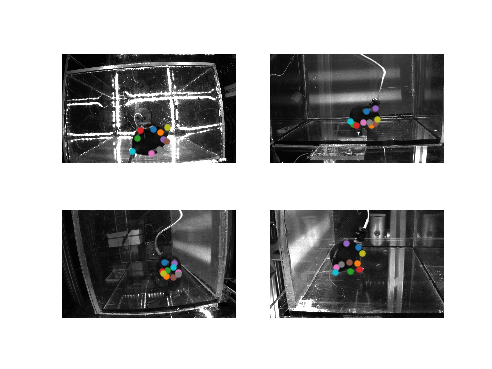

In [14]:
#visualize the predictions on individual views
_= PlotMouseImages(path2base,'00000864.png')

In [ ]:
# now we transform the keypoint coordinates into rats reference frame

In [10]:
from trafo_utils import trafo2local
""" Transforms global keypoints into a rat local coordinate frame

    The rat local system is spanned by:
        - x: Animal right  (perpendicular to ground plane normal and body axis)
        - y: The body axis (defined by the vector from tail to a point between the ears)
        - z: Animal up (perpendicular to x and y)
    And located in the point midway between the two ear keypoints.
"""

rat_pose_timepoint1=np.squeeze(np.array(preds["00000864.png"]["kp_xyz"]))
local_rat_pose_timepoint1 = trafo2local(rat_pose_timepoint1)
#head_local_rat = trafo2HEADlocal(origin_rat)

rat_pose_timepoint2=np.squeeze(np.array(preds['00009504.png']["kp_xyz"]))
local_rat_pose_timepoint2 = trafo2local(rat_pose_timepoint2)
#head_local_rat2 = trafo2HEADlocal(origin_rat2)



In [12]:
from mpl_toolkits.mplot3d import Axes3D
def plotXYZcross(size=0.05,offset=0.01):
    origin=[0,0,0]
    origin+=np.tile(offset,3)
    xorigin=[size,0.0,0]
    x,y,z=zip(origin,origin+xorigin)
    plt.plot(x,y,z,'-',c='b')
    yorigin=[0.,size,0]
    x,y,z=zip(origin,origin+yorigin)
    plt.plot(x,y,z,'-',c='r')
    zorigin=[0.,0.,size]
    x,y,z=zip(origin,origin+zorigin)
    plt.plot(x,y,z,'-',c='g')
def PlotMouseSkel3D(rat2plot,c='k',transformed=False):
    rat=np.copy(rat2plot)
    if transformed:
        bt=np.copy(rat2plot)
        rat[:,0]=bt[:,1]
        rat[:,2]=-bt[:,0]
        rat[:,1]=bt[:,2]
    
    neck=(rat[0,:]+rat[4,:])/2    
    bodyaxis=neck-rat[9,:]
    head_axis=rat[8,:]-neck
    
    for p in rat:    
        plt.plot([p[0],p[0]],[p[1],p[1]],[p[2],p[2]],marker='.',markersize=5)    
    x,y,z=zip(rat[8,:],neck)
    plt.plot(x,y,z,'-',c=c)
    x,y,z=zip(rat[9,:],neck)
    plt.plot(x,y,z,'-',c=c)
    x,y,z=zip(rat[0,:],neck)
    plt.plot(x,y,z,'-',c=c)
    x,y,z=zip(rat[4,:],neck)
    plt.plot(x,y,z,'-',c=c)

    x,y,z=zip(rat[4,:],rat[8,:])
    plt.plot(x,y,z,'-',c=c)
    x,y,z=zip(rat[0,:],rat[8,:])
    plt.plot(x,y,z,'-',c=c)

    x,y,z=zip(rat[1,:],(neck-0.3*bodyaxis))
    plt.plot(x,y,z,'-',c=c)
    x,y,z=zip(rat[5,:],(neck-0.3*bodyaxis))
    plt.plot(x,y,z,'-',c=c)

    x,y,z=zip(rat[2,:],rat[3,:])
    plt.plot(x,y,z,'-',c=c)
    x,y,z=zip(rat[2,:],(neck-0.7*bodyaxis))
    plt.plot(x,y,z,'-',c=c)

    x,y,z=zip(rat[6,:],rat[7,:])
    plt.plot(x,y,z,'-',c=c)
    x,y,z=zip(rat[6,:],(neck-0.7*bodyaxis))
    plt.plot(x,y,z,'-',c=c)

<IPython.core.display.Javascript object>


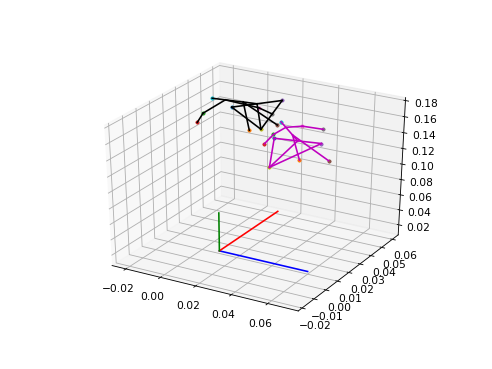

In [15]:
# Using keypoints in global coordinates we can visualize the position of the animal in space
# however, its more difficult to describe the relative motion of e.g. paw due to global movement of the animal 
# thus frame by frame movement of the paw is combination of actual movement of the paw plus the movement of the boy in space

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plotXYZcross()
PlotMouseSkel3D(rat_pose_timepoint1,c='k')
PlotMouseSkel3D(rat_pose_timepoint2,c='m')

<IPython.core.display.Javascript object>


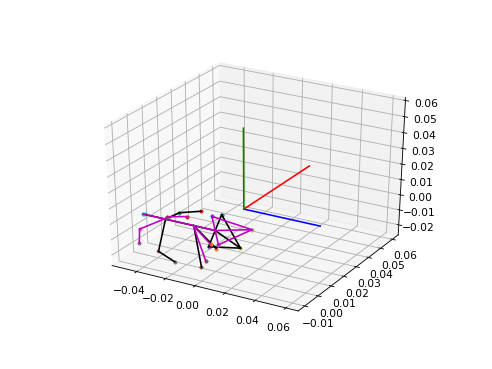

In [16]:
# If we, however, transfer the coordinates into rat local reference frame base on the body axis of the animal we can easily visualize the relative motion of body parts
# Now the movements of the paw represent just the paw movement relativ to body with global body movement removed
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plotXYZcross()
PlotMouseSkel3D(local_rat_pose_timepoint1,c='k',transformed=True)
PlotMouseSkel3D(local_rat_pose_timepoint2,c='m',transformed=True)
